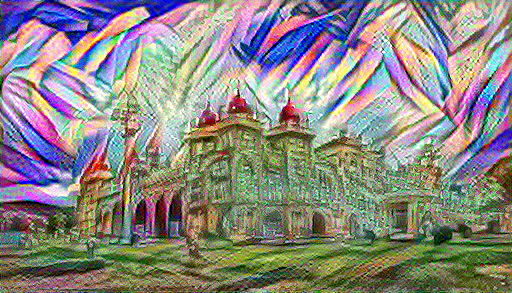

Completed epoch 3


In [ ]:
# %% Import necessary libraries
import os
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import time
import functools

# Configure matplotlib for better visualization
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['axes.grid'] = False

# %% Function to convert tensor to image format
def tensor_to_image(tensor):
    tensor = tensor * 255
    array = np.array(tensor, dtype=np.uint8)
    if array.ndim > 3:
        array = array[0]
    return PIL.Image.fromarray(array)

# %% Additional Imports for Style Transfer
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import vgg19

# %% Function to load and process images
def load_image(path):
    max_dim = 512
    image_data = tf.io.read_file(path)
    img = tf.image.decode_image(image_data, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    original_shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = tf.reduce_max(original_shape)
    scale_factor = max_dim / long_dim
    new_shape = tf.cast(original_shape * scale_factor, tf.int32)

    return tf.image.resize(img, new_shape)[tf.newaxis, :]

# %% Define paths for content and style images
content_path = r"C:\Users\user\Downloads\Mysuru-Palace-banner.png"
style_path = r'C:\Users\user\Downloads\images.png'

# %% Display function for visualizing images
def display_image(image, title=None):
    if image.shape[0] > 1:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

# %% Load and display content and style images
content_img = load_image(content_path)
style_img = load_image(style_path)


# %% Preprocess the image and load VGG19 model for initial predictions
x = tf.keras.applications.vgg19.preprocess_input(content_img * 255)
x = tf.image.resize(x, (224, 224))
vgg_model = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probs = vgg_model(x)
predicted_classes = tf.keras.applications.vgg19.decode_predictions(prediction_probs.numpy())[0]

# %% Display top-5 predictions for content image
[(class_name, prob) for (_, class_name, prob) in predicted_classes]

# %% Load VGG19 model with only convolutional layers
vgg_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

# Print layer names to identify desired content and style layers
print("Available layers for VGG19:")
for layer in vgg_model.layers:
    print(layer.name)

# %% Select specific layers for content and style extraction
content_layer = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
num_style_layers = len(style_layers)

# %% Define a model to extract specified layers from VGG
def build_vgg_model(layers):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layers]
    return tf.keras.Model([vgg.input], outputs)

# %% Initialize style and content extraction models
style_extractor = build_vgg_model(style_layers)
style_outputs = style_extractor(style_img * 255)
# Display statistics for each layer's output
for name, output in zip(style_layers, style_outputs):
    print(f"{name} - shape: {output.shape}, min: {tf.reduce_min(output).numpy()}, max: {tf.reduce_max(output).numpy()}, mean: {tf.reduce_mean(output).numpy()}")


# %% Function to compute the Gram matrix for style layers
def gram_matrix(tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', tensor, tensor)
    return result / tf.cast(tf.shape(tensor)[1] * tf.shape(tensor)[2], tf.float32)

# %% Define StyleContentModel to extract features
class StyleContentExtractor(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentExtractor, self).__init__()
        self.vgg = build_vgg_model(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed)
        style_outputs, content_outputs = outputs[:self.num_style_layers], outputs[self.num_style_layers:]

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        return {'style': dict(zip(self.style_layers, style_outputs)),
                'content': dict(zip(self.content_layers, content_outputs))}

# %% Initialize and run feature extraction
extractor = StyleContentExtractor(style_layers, content_layer)
features = extractor(tf.constant(content_img))

# %% Set up training loop and define loss function
style_targets = extractor(style_img)['style']
content_targets = extractor(content_img)['content']

# Initialize image variable and optimizer
image = tf.Variable(content_img)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# Define loss function
def compute_loss(outputs, style_weight=1e-2, content_weight=1e4):
    style_loss = tf.add_n([tf.reduce_mean((outputs['style'][name] - style_targets[name]) ** 2) for name in style_targets])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((outputs['content'][name] - content_targets[name]) ** 2) for name in content_targets])
    content_loss *= content_weight
    return style_loss + content_loss

# %% Training step function
@tf.function()
def apply_style_transfer_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = compute_loss(outputs)
        loss += 30 * tf.image.total_variation(image)
    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, 0.0, 1.0))

# %% Run the training loop
for epoch in range(8):
    for _ in range(70):
        apply_style_transfer_step(image)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print(f"Completed epoch {epoch + 1}")

# Save final image
output_path = 'stylized_image.png'
tensor_to_image(image).save(output_path)
print(f"Image saved to {output_path}")
